In [125]:
import pandas as pd 
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import nltk
import string 
from tqdm import tqdm
import warnings
warnings.filterwarnings('ignore')
from collections import Counter

from plotly import graph_objs as go
import plotly.express as px
import plotly.figure_factory as ff

from sklearn.feature_extraction.text import TfidfVectorizer 

from wordcloud import WordCloud, STOPWORDS

from sklearn.model_selection import train_test_split

from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.pipeline import Pipeline, make_pipeline, FeatureUnion
from sklearn.compose import ColumnTransformer, make_column_selector
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression, LogisticRegressionCV

from string import punctuation
from sklearn.metrics import roc_auc_score, confusion_matrix
import eli5

## EDA

In [2]:
columns = ['artist', 'album', 'review', 'release_date', 'rating', 'user', 'language']
df = pd.read_csv('rym_data.csv', names=columns)

In [3]:
df.head()

,artist,album,review,release_date,rating,user,language
0,Chevelle,Niratias,"haha the ""tool for non incels"" type comments ...",5 March 2021,2.00 stars,robot_tree,en
1,PACHI87,Fightclub Chinatown,"It's a mashup of Yasuha's ""Fly-day Chinatown""...",28 November 2019,4.00 stars,granbull21,en
2,Opeth,Pale Communion,"After a strong start, the album includes a fe...",26 August 2014,3.50 stars,artyomkur,en
3,Det eviga leendet,Reverence,"""Reverence"" continues the path Det eviga leen...",28 January 2022,4.00 stars,Rinbel,en
4,J. Karjalainen,Soulavaris,And J. Karjalainen. Some Finnish journalists ...,1 April 2022,3.50 stars,fairyeee,en


In [4]:
df.shape

(3120, 7)

In [5]:
df.drop_duplicates(inplace=True)
df.shape

(2274, 7)

In [6]:
df['len_review'] = df.review.apply(lambda x: len(str(x)))

In [8]:
df['int_rating'] = df.rating.apply(lambda x: -1 if x == 'no_rating' else x)
df['int_rating'] = df.int_rating.apply(lambda x: -1 if x == -1 else float(x.split(' ')[0])*2)

In [9]:
df['release_date_dt']=pd.to_datetime(df.release_date, errors='coerce')

<AxesSubplot:xlabel='int_rating', ylabel='Count'>

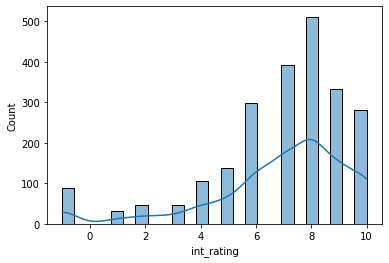

In [10]:
sns.histplot(data=df, x="int_rating", kde=True)

<AxesSubplot:xlabel='len_review', ylabel='Count'>

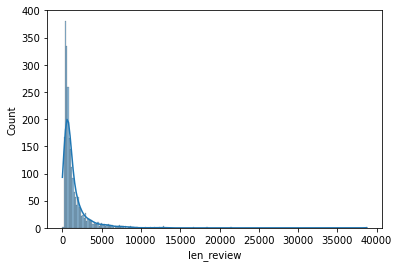

In [11]:
sns.histplot(data=df, x="len_review", kde=True)

In [12]:
df['year'] = pd.DatetimeIndex(df.release_date_dt).year

<AxesSubplot:xlabel='year', ylabel='int_rating'>

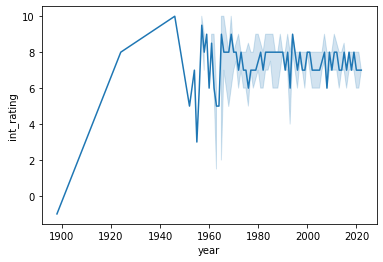

In [13]:
sns.lineplot(x="year", y="int_rating", data=df, estimator=np.median)

In [14]:
df.describe(include='all')

,artist,album,review,release_date,rating,user,language,len_review,int_rating,release_date_dt,year
count,2274,2274,2274,2274,2274,2274,2274,2274.000000,2274.000000,2262,2262.000000
unique,1503,1793,2124,1191,11,894,16,NaN,NaN,1184,NaN
top,Kendrick Lamar,Mr. Morale & The Big Steppers,This is a very important release for this ban...,13 May 2022,4.00 stars,steelesman10,en,NaN,NaN,2022-05-13 00:00:00,NaN
freq,140,123,3,202,511,111,1948,NaN,NaN,202,NaN
first,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1898-01-01 00:00:00,NaN
last,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2022-09-30 00:00:00,NaN
mean,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1410.756816,6.912489,NaN,2006.238285
std,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1994.972149,2.562169,NaN,17.097615
min,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2.000000,-1.000000,NaN,1898.000000
25%,NaN,NaN,NaN,NaN,NaN,NaN,NaN,489.250000,6.000000,NaN,1995.000000


In [15]:
df.groupby('artist').int_rating.median().sort_values(ascending=False)

artist
Sami Kukka           10.0
Maxo Kream           10.0
Car Seat Headrest    10.0
Cardiacs             10.0
Carly Rae Jepsen     10.0
                     ... 
Greta Van Fleet      -1.0
Grant                -1.0
Salmo                -1.0
Orchid               -1.0
End of Green         -1.0
Name: int_rating, Length: 1503, dtype: float64

In [16]:
df.loc[df.int_rating == -1]

,artist,album,review,release_date,rating,user,language,len_review,int_rating,release_date_dt,year
35,Kendrick Lamar,Mr. Morale & The Big Steppers,ok delvin a bit into each track. \n \n - unit...,13 May 2022,no_rating,grandson,en,2352,-1.0,2022-05-13,2022.0
40,Kid Rock,"Lovesick, Broke & Driftin'",Not content spending 2000 conquering the worl...,27 August 2001,no_rating,Matt_K,en,2882,-1.0,2001-08-27,2001.0
119,Boredoms,Another World,"Excellent and surprisingly cheerful set, simi...",21 April 2022,no_rating,Phallus_Dei,en,384,-1.0,2022-04-21,2022.0
137,Ital Tek,Outland,Когда я познакомился с творчеством Ital Tek л...,1 May 2020,no_rating,F7sh3r,ru,2684,-1.0,2020-05-01,2020.0
171,Bobby Swope,World Receiver,Accomplishes what I love about basically all ...,11 June 1996,no_rating,in_an_emergency,en,274,-1.0,1996-06-11,1996.0
...,...,...,...,...,...,...,...,...,...,...,...
2150,Kygo,It Ain't Me,This song's lyrics are fine - strained breaku...,17 February 2017,no_rating,Inevio,en,1128,-1.0,2017-02-17,2017.0
2155,The Cure,Wap Konn Jòj!,Track breakdown:\n \n Chiney Bush: Very nice ...,21 June 2019,no_rating,YAWK_YAWK_YAWK,en,1596,-1.0,2019-06-21,2019.0
3048,Forenzics,Shades and Echoes,The reformation of three original Split Enz m...,4 February 2022,no_rating,Matt_K,en,1747,-1.0,2022-02-04,2022.0
3058,Kids See Ghosts,The Party's Over,So I decided to listen to Talk Talk from st...,12 July 1982,no_rating,Malkovith1,en,960,-1.0,1982-07-12,1982.0


In [17]:
def artist_by_album_rating(artist_name, dataframe=df):
    plt.subplots(figsize=(15,10))
    artist_by_album = df.loc[df.artist == artist_name].groupby('album')['int_rating'].mean()
    pal = sns.color_palette("Greens_d", len(artist_by_album))
    rank = artist_by_album.argsort().argsort()   # http://stackoverflow.com/a/6266510/1628638
    ax=sns.barplot(artist_by_album.index, artist_by_album.values, palette=np.array(pal[::-1])[rank])
    ax.set_xticklabels(ax.get_xticklabels(), rotation=40, ha="right")
    plt.show()
    plt.tight_layout()
    
    print(artist_by_album.sort_values(ascending=False).head(3))

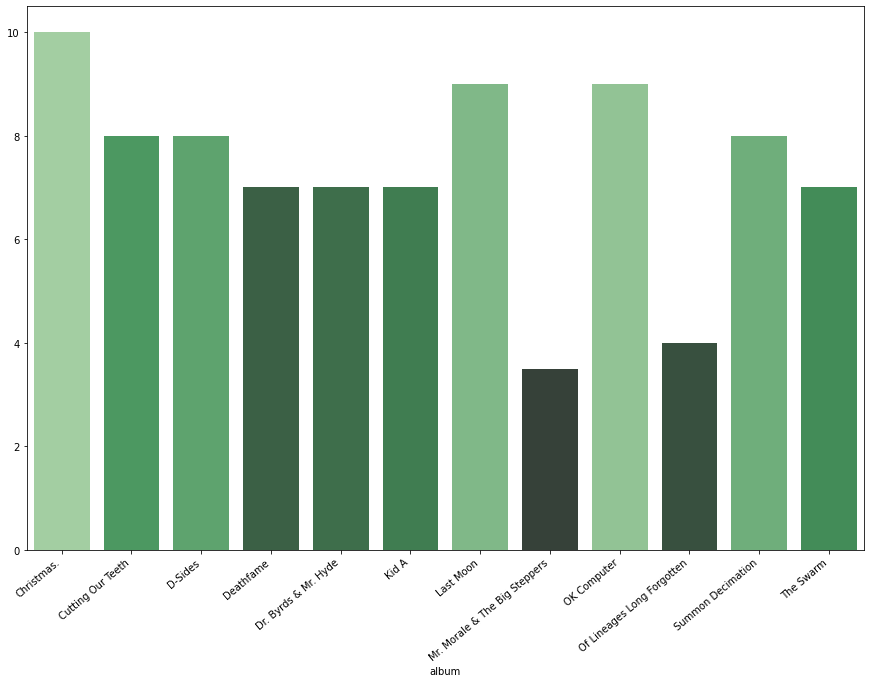

album
Christmas.     10.0
Last Moon       9.0
OK Computer     9.0
Name: int_rating, dtype: float64


<Figure size 432x288 with 0 Axes>

In [19]:
artist_by_album_rating('Radiohead')

In [20]:
num_user_reviews=df.groupby('user')['user'].count().sort_values(ascending=False)

In [21]:
num_user_reviews[num_user_reviews.values >10]

user
steelesman10         111
dimdim23              65
nordyquist            36
Tyrcrash              34
corkie                24
ajcollins15           23
geldofpunk            22
MookidRhubarb         21
pp789                 20
sourcoffee            20
p_q                   19
inthebeginning        18
shiba7                17
rile                  16
TheDice               15
Lejink                14
Verminous             13
bnoring               13
ListyGuy              13
Vernon_Warez          12
RDTEN1                12
IrritableSatirist     12
neutral_fox_hotel     11
one_imaginaryboy_     11
Fastro                11
ChuggaChugga          11
UMUR                  11
dewtaylo              11
Disink                11
GrapeOfWrath          11
astroturf78           11
Name: user, dtype: int64

In [24]:
df_en = df.loc[df['language'] == 'en']


In [25]:
stop_words = nltk.corpus.stopwords.words('english')
word_tokenizer = nltk.WordPunctTokenizer()
corpus = df_en.review.values

In [26]:
stop_words.append(['“','“'])

In [28]:
def process_words(corpus):
    texts=[]
    for item in corpus:
        text_lower = item.lower()
        tokens = word_tokenizer.tokenize(text_lower)

        tokens = [word for word in tokens if (word not in string.punctuation and word not in stop_words)]
        texts.append(tokens)
        
    return texts

In [29]:
proccesed_texts = process_words(corpus)

In [30]:
from nltk.stem import WordNetLemmatizer

lemmatizer = WordNetLemmatizer()

In [31]:
texts_lemmatized = []
# tqdm_notebook создает шкалу прогресCountVectorizerса :)
for i in tqdm(range(len(proccesed_texts))):
    text_lemmatized = [lemmatizer.lemmatize(x) for x in proccesed_texts[i]]
    texts_lemmatized.append([text_lemmatized])
    texts_lemmatized[i] = ' '.join(text_lemmatized)

100%|██████████████████████████████████████| 1948/1948 [00:04<00:00, 394.91it/s]


In [32]:
df_en['text_lemmatized']=texts_lemmatized

In [33]:
df_en['temp_list'] = df_en['text_lemmatized'].apply(lambda x: str(x).split())
top = Counter([item for sublist in df_en['temp_list'] for item in sublist])
temp = pd.DataFrame(top.most_common(20))
temp.columns = ['Common_words', 'count']
temp.style.background_gradient(cmap='Blues')

,Common_words,count
0,album,5363
1,’,3387
2,like,3166
3,song,3121
4,track,2533
5,one,2178
6,really,1624
7,sound,1622
8,time,1435
9,music,1398


In [35]:
fig = px.treemap(temp, path=['Common_words'], values='count',title='Tree of Most Common Words')
fig.show()

In [36]:
perf_album = df_en[df_en.int_rating == 10]
bad_album = df_en[(df_en.int_rating <2) & (df_en.int_rating >0)]

In [37]:
top = Counter([item for sublist in perf_album['temp_list'] for item in sublist])
temp = pd.DataFrame(top.most_common(20))
temp.columns = ['Common_words', 'count']
temp.style.background_gradient(cmap='Greens')

,Common_words,count
0,album,799
1,’,467
2,like,393
3,song,381
4,one,332
5,track,286
6,time,240
7,really,232
8,music,213
9,sound,190


In [44]:
top = Counter([item for sublist in bad_album['temp_list'] for item in sublist])
temp = pd.DataFrame(top.most_common(20))
temp.columns = ['Common_words', 'count']
temp.style.background_gradient(cmap='Reds')

,Common_words,count
0,song,47
1,like,39
2,’,29
3,make,28
4,album,22
5,lyric,21
6,get,21
7,music,19
8,bad,18
9,vocal,18


In [38]:
raw_text = [word for word_list in df_en['temp_list'] for word in word_list]

In [39]:
def words_unique(rating, numwords, raw_words):
    '''
    Input:
        rating - rating category (ex. 'Neutral');
        numwords - how many specific words do you want to see in the final result; 
        raw_words - list  for item in df_en['temp_list']:
    Output: 
        dataframe giving information about the name of the specific word and how many times it occurs in the chosen rating  (in descending order based on their counts)..

    '''
    allother = []
    for item in df_en[df_en.int_rating != rating]['temp_list']:
        for word in item:
            allother .append(word)
    allother = list(set(allother))

    specificnonly = [x for x in raw_text if x not in allother]

    mycounter = Counter()

    for item in df_en[df_en.int_rating == rating]['temp_list']:
        for word in item:
            mycounter[word] += 1
    keep = list(specificnonly)

    for word in list(mycounter):
        if word not in keep:
            del mycounter[word]

    Unique_words = pd.DataFrame(mycounter.most_common(
        numwords), columns=['words', 'count'])

    return Unique_words

In [40]:
words_unique(10, 20, raw_text)

,words,count
0,kero,20
1,bonito,19
2,tp,12
3,dubstar,9
4,zevon,8
5,rowland,7
6,phantom,5
7,gibson,5
8,daveed,5
9,vliet,4


In [41]:
df_en['verbal_rating'] = df_en.int_rating.apply(lambda x: 'good' if x >=8 else ('bad' if x <=2 else 'neutral'))

In [42]:
good_rev = df_en[df_en.verbal_rating == 'good']
good_text = ' '.join(review for review in good_rev['text_lemmatized'])

neutral_rev = df_en[df_en.verbal_rating == 'neutral']
neutral_text = ' '.join(review for review in neutral_rev['text_lemmatized'])

bad_rev = df_en[df_en.verbal_rating == 'bad']
bad_text = ' '.join(review for review in bad_rev['text_lemmatized'])

In [47]:
stopwords = set(STOPWORDS)
stopwords.update(['album', 'track', 'song', 'music', 'one', 'sound','really'])


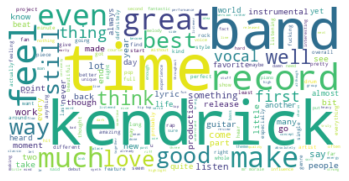

In [48]:
wordcloud = WordCloud(stopwords=stopwords,background_color="white").generate(good_text)
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()

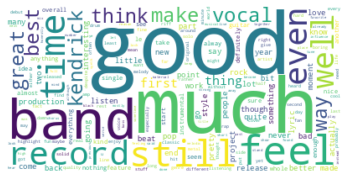

In [49]:
wordcloud = WordCloud(stopwords=stopwords,background_color="white").generate(neutral_text)
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()

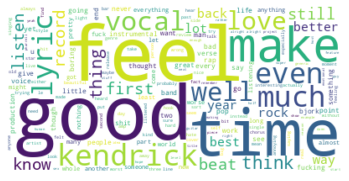

In [50]:
wordcloud = WordCloud(stopwords=stopwords,background_color="white").generate(bad_text)
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()

## Modelling

In [55]:
df_en['year'].fillna(0, inplace=True)
df_en= df_en.loc[df_en['int_rating'] >0]

In [76]:
X_train, X_test, y_train, y_test = train_test_split(
    df_en.drop(['int_rating'], axis=1), df_en.int_rating, test_size=0.20, random_state=63, stratify=df_en.int_rating)

In [77]:
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((1494, 13), (374, 13), (1494,), (374,))

In [78]:
X_train = X_train[['artist', 'album', 'user', 'release_date', 'year', 'text_lemmatized', 'len_review']]

In [79]:
X_train['text_lemmatized']

1593    recommended german band called cornocupia assu...
1465    despite admittedly slightly pretentious name c...
1431    album venture bit boring side definitely see t...
1002    like party start really fun like tired wanna g...
377     man ... really wish liquid stranger could come...
                              ...                        
1364    mixing electronica jazz fundamental part moder...
1339    solid 3ish year since zuu get denzel next full...
521     second release fujiwara innovative triple doub...
698     behind wall far away one highlight let bad tim...
3062    first 5 single album bad hit 1 let sink minute...
Name: text_lemmatized, Length: 1494, dtype: object

### Creating pipeline

In [80]:
class ListPreparator(BaseEstimator, TransformerMixin):
    '''Prepares a vectorizer friendly list '''
    
    def fit(self, X, y=None):
        return self
    def transform(self, X, y=None):
        return X['text_lemmatized'].values

In [81]:
class AddScaleFeatures(BaseEstimator, TransformerMixin):
    '''Add new features that needs to be scaled'''

    def fit(self, X, y=None):
        return self
    
    def transform(self, X, y=None):
        year = X['year'].values
        len_review = X['len_review'].values

        X = np.c_[year, len_review]

        return X

In [145]:
vectorizer_pipeline = Pipeline([
                               ('list_preparator', ListPreparator()),
                               ('vectorizer', TfidfVectorizer(ngram_range=(1,2), max_features=50000, norm=False))])


add_scaled_f_pipeline = Pipeline([('sc_adder', AddScaleFeatures()),
                                 ('scaler' , StandardScaler())
                                 ])

preprocessor = FeatureUnion(transformer_list=[
    ('vectorizer_pipeline', vectorizer_pipeline),
    ('add_scaled_f_pipeline', add_scaled_f_pipeline),
])

In [146]:
clf_pipeline = Pipeline(
    steps=[("preprocessor", preprocessor), 
           ("classifier", LogisticRegression(C=0.04641589,solver='lbfgs', random_state=63))])

In [147]:
clf_pipeline.fit(X_train, y_train)

Pipeline(steps=[('preprocessor',
                 FeatureUnion(transformer_list=[('vectorizer_pipeline',
                                                 Pipeline(steps=[('list_preparator',
                                                                  ListPreparator()),
                                                                 ('vectorizer',
                                                                  TfidfVectorizer(max_features=50000,
                                                                                  ngram_range=(1,
                                                                                               2),
                                                                                  norm=False))])),
                                                ('add_scaled_f_pipeline',
                                                 Pipeline(steps=[('sc_adder',
                                                                  AddScaleFeatures()),
        

In [148]:
y_pred_prob=clf_pipeline.predict_proba(X_test)

In [149]:
roc_auc_score(y_test, y_pred_prob, multi_class='ovr')

0.761939025522891

In [150]:
matrix_confusion=confusion_matrix(y_test, clf_pipeline.predict(X_test), labels=labels)

In [151]:
def make_confusion_matrix(cf,
                          group_names=None,
                          categories='auto',
                          count=True,
                          percent=True,
                          cbar=True,
                          xyticks=True,
                          xyplotlabels=True,
                          sum_stats=True,
                          figsize=None,
                          cmap='Blues',
                          title=None):
    '''
    This function will make a pretty plot of an sklearn Confusion Matrix cm using a Seaborn heatmap visualization.
    Arguments
    ---------
    cf:            confusion matrix to be passed in
    group_names:   List of strings that represent the labels row by row to be shown in each square.
    categories:    List of strings containing the categories to be displayed on the x,y axis. Default is 'auto'
    count:         If True, show the raw number in the confusion matrix. Default is True.
    normalize:     If True, show the proportions for each category. Default is True.
    cbar:          If True, show the color bar. The cbar values are based off the values in the confusion matrix.
                   Default is True.
    xyticks:       If True, show x and y ticks. Default is True.
    xyplotlabels:  If True, show 'True Label' and 'Predicted Label' on the figure. Default is True.
    sum_stats:     If True, display summary statistics below the figure. Default is True.
    figsize:       Tuple representing the figure size. Default will be the matplotlib rcParams value.
    cmap:          Colormap of the values displayed from matplotlib.pyplot.cm. Default is 'Blues'
                   See http://matplotlib.org/examples/color/colormaps_reference.html
                   
    title:         Title for the heatmap. Default is None.
    '''


    # CODE TO GENERATE TEXT INSIDE EACH SQUARE
    blanks = ['' for i in range(cf.size)]

    if group_names and len(group_names)==cf.size:
        group_labels = ["{}\n".format(value) for value in group_names]
    else:
        group_labels = blanks

    if count:
        group_counts = ["{0:0.0f}\n".format(value) for value in cf.flatten()]
    else:
        group_counts = blanks

    if percent:
        group_percentages = ["{0:.2%}".format(value) for value in cf.flatten()/np.sum(cf)]
    else:
        group_percentages = blanks

    box_labels = [f"{v1}{v2}{v3}".strip() for v1, v2, v3 in zip(group_labels,group_counts,group_percentages)]
    box_labels = np.asarray(box_labels).reshape(cf.shape[0],cf.shape[1])


    # CODE TO GENERATE SUMMARY STATISTICS & TEXT FOR SUMMARY STATS
    if sum_stats:
        #Accuracy is sum of diagonal divided by total observations
        accuracy  = np.trace(cf) / float(np.sum(cf))

        #if it is a binary confusion matrix, show some more stats
        if len(cf)==2:
            #Metrics for Binary Confusion Matrices
            precision = cf[1,1] / sum(cf[:,1])
            recall    = cf[1,1] / sum(cf[1,:])
            f1_score  = 2*precision*recall / (precision + recall)
            stats_text = "\n\nAccuracy={:0.3f}\nPrecision={:0.3f}\nRecall={:0.3f}\nF1 Score={:0.3f}".format(
                accuracy,precision,recall,f1_score)
        else:
            stats_text = "\n\nAccuracy={:0.3f}".format(accuracy)
    else:
        stats_text = ""


    # SET FIGURE PARAMETERS ACCORDING TO OTHER ARGUMENTS
    if figsize==None:
        #Get default figure size if not set
        figsize = plt.rcParams.get('figure.figsize')

    if xyticks==False:
        #Do not show categories if xyticks is False
        categories=False


    # MAKE THE HEATMAP VISUALIZATION
    plt.figure(figsize=figsize)
    sns.heatmap(cf,annot=box_labels,fmt="",cmap=cmap,cbar=cbar,xticklabels=categories,yticklabels=categories)

    if xyplotlabels:
        plt.ylabel('True label')
        plt.xlabel('Predicted label' + stats_text)
    else:
        plt.xlabel(stats_text)
    
    if title:
        plt.title(title)

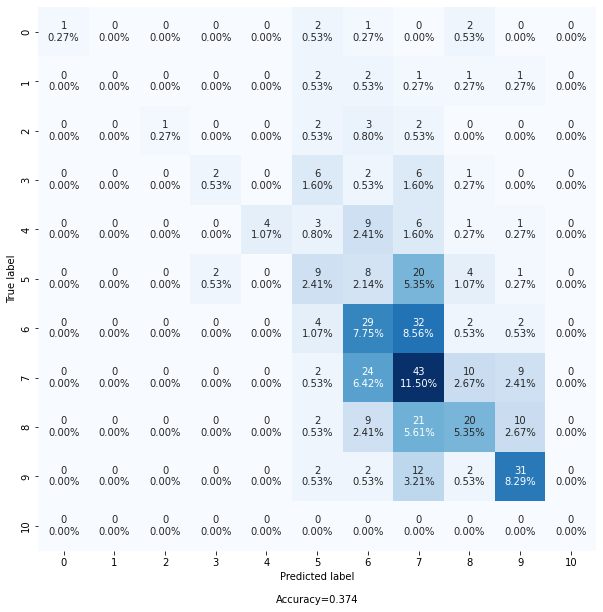

In [152]:
make_confusion_matrix(matrix_confusion, figsize=(10,10), cbar=False)

I couldn't find a way to implement eli5 features with pipeline, so let's use tfidf and see which words and bigrams are most occuring for each category 

In [153]:
tfidf= TfidfVectorizer(max_features=50000, ngram_range=(1,2), norm=False)
tfidf_train=tfidf.fit_transform(X_train['text_lemmatized'])
tfidf_test=tfidf.transform(X_test['text_lemmatized'])

clf= LogisticRegression(C=0.04641589, solver='lbfgs', random_state=63)

clf.fit(tfidf_train, y_train)

LogisticRegression(C=0.04641589, random_state=63)

In [154]:
eli5.show_weights(clf, top=10)

eli5.show_weights(clf, vec=tfidf)

In [155]:
eli5.show_prediction(clf, X_test['text_lemmatized'].values[0], vec=tfidf,
                     )

In [129]:
clf.C_

array([0.04641589, 0.04641589, 0.04641589, 0.04641589, 0.04641589,
       0.04641589, 0.04641589, 0.04641589, 0.04641589, 0.04641589])